# NLP: проект “Классификация новостных заголовков” (Word2Vec + LogisticRegression)

**Формат:** ввод → пайплайн → практика Word2Vec → обучение модели → метрики → сохранение → тест на новых заголовках → **10 заданий** (код с пропусками).
**Цель:** понять, как **эмбеддинги Word2Vec** помогают решать задачи NLP.

---

## Что мы сделаем за занятие
✅ Загрузим датасет новостных заголовков (headline + category)  
✅ Сделаем минимальный EDA  
✅ Почистим и токенизируем заголовки  
✅ Обучим **Word2Vec** на заголовках  
✅ Превратим каждый заголовок в вектор (mean pooling)  
✅ Обучим классификатор **LogisticRegression**  
✅ Оценим качество (accuracy + confusion matrix + report)  
✅ Сохраним модель и протестируем на новых заголовках


In [1]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 71.0 MB/s eta 0:00:00


In [2]:
# Если запускаете локально:
# !pip install pandas numpy scikit-learn gensim matplotlib seaborn nltk joblib --quiet

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from gensim.models import Word2Vec
import joblib

import nltk
from nltk.tokenize import word_tokenize

np.random.seed(42)
sns.set_style("whitegrid")

print("Ready ✅")

Ready ✅


## 0) Скачиваем NLTK tokenizer (1 раз)

Для токенизации нам нужен `punkt`.


In [3]:
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# 1) Ввод: зачем Word2Vec в NLP?

## Какие бывают задачи NLP?
- классификация текста (спам, тема новости, токсичность)
- поиск похожих текстов
- анализ тональности
- ответы на вопросы

---

## Почему нельзя просто “скормить” текст модели?
Потому что модель работает с числами.

Нужен путь:
**текст → токены → числа → модель**

---

## Что такое Word2Vec?
Word2Vec учит **вектора слов** так, чтобы:
- слова, встречающиеся в похожих контекстах, были “близко”
- смысл кодировался координатами вектора

Очень простая мысль:
✅ “слова дружат, если часто встречаются рядом”


# 2) Пайплайн решения задачи (универсальный шаблон)

1) **Загрузка данных**
   - headline (текст)
   - category (класс)

2) **Мини-EDA**
   - сколько классов?
   - баланс классов
   - длины заголовков

3) **Preprocessing**
   - lower()
   - убрать мусорные символы
   - токенизация

4) **Embeddings (Word2Vec)**
   - обучаем Word2Vec на всех заголовках (train)
   - получаем вектор каждого слова

5) **Документ-вектор**
   - заголовок состоит из слов
   - возьмём **среднее** embedding слов
   - получим вектор фиксированной длины

6) **Train/Test split**

7) **Классификатор**
   - LogisticRegression (быстро и понятно)

8) **Оценка качества**
   - accuracy
   - confusion matrix
   - classification_report

9) **Сохранение и применение**
   - сохраняем Word2Vec
   - сохраняем модель
   - тестируем на новых заголовках


# 3) Датасет новостных заголовков

### Вариант A (Kaggle / свой CSV)
Если у вас есть CSV (например Kaggle `News Category Dataset`), то структура часто такая:
- `headline` или `title`
- `category`

Тогда просто:
```python
df = pd.read_csv("your_file.csv")
df = df[["headline","category"]]
```

### Вариант B (учебный mini dataset)
Если интернета/файла нет — мы используем небольшой учебный датасет прямо в ноутбуке.

> Важно: логика обучения одинакова. На большом датасете просто качество будет выше.


In [4]:
# ===== Вариант A: загрузка своего CSV (раскомментируйте и укажите путь) =====
# df = pd.read_csv("news.csv")
# df = df.rename(columns={"title":"headline"})  # если нужно
# df = df[["headline", "category"]].dropna()

# ===== Вариант B: учебный mini dataset =====
data = [
    ("sports", "Real Madrid wins dramatic match in extra time"),
    ("sports", "NBA star scores 50 points in playoff thriller"),
    ("sports", "Olympic champion sets new world record in sprint"),
    ("tech", "Apple announces new iPhone with faster chip"),
    ("tech", "Breakthrough in quantum computing boosts performance"),
    ("tech", "Cybersecurity experts warn about new malware attack"),
    ("business", "Stock markets rise as inflation slows down"),
    ("business", "Company reports record profits this quarter"),
    ("business", "Oil prices fall after global demand weakens"),
    ("politics", "Government passes new law after heated debate"),
    ("politics", "President meets foreign leaders at summit"),
    ("politics", "Elections spark protests in major cities"),
    ("health", "Doctors recommend new vaccine for flu season"),
    ("health", "Study shows benefits of daily walking"),
    ("health", "Hospitals face shortage of medical staff"),
    ("science", "NASA discovers new planet that may support life"),
    ("science", "Researchers create new material stronger than steel"),
    ("science", "Climate report warns about rising sea levels"),
]

df = pd.DataFrame(data, columns=["category", "headline"])

print("df shape:", df.shape)
df.head()

df shape: (18, 2)


,category,headline
0,sports,Real Madrid wins dramatic match in extra time
1,sports,NBA star scores 50 points in playoff thriller
2,sports,Olympic champion sets new world record in sprint
3,tech,Apple announces new iPhone with faster chip
4,tech,Breakthrough in quantum computing boosts perfo...


# 4) Мини-EDA (быстро и полезно)

Смотрим:
- сколько классов
- баланс классов
- длину заголовков


Classes: 6


,count
category,
sports,3
tech,3
business,3
politics,3
health,3
science,3


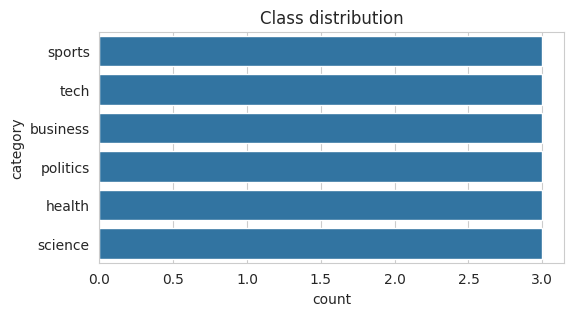

In [5]:
print("Classes:", df["category"].nunique())
display(df["category"].value_counts())

plt.figure(figsize=(6,3))
sns.countplot(y="category", data=df, order=df["category"].value_counts().index)
plt.title("Class distribution")
plt.show()

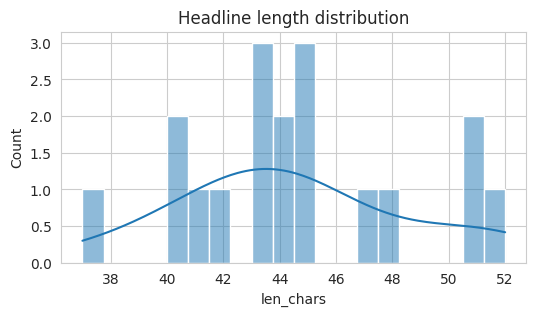

,category,headline,len_chars
0,sports,Real Madrid wins dramatic match in extra time,45
1,sports,NBA star scores 50 points in playoff thriller,45
8,business,Oil prices fall after global demand weakens,43
5,tech,Cybersecurity experts warn about new malware a...,51
3,tech,Apple announces new iPhone with faster chip,43


In [6]:
df["len_chars"] = df["headline"].astype(str).apply(len)

plt.figure(figsize=(6,3))
sns.histplot(df["len_chars"], bins=20, kde=True)
plt.title("Headline length distribution")
plt.xlabel("len_chars")
plt.show()

df[["category","headline","len_chars"]].sample(5, random_state=42)

# 5) Preprocessing + токенизация

Мы сделаем супер базовую подготовку текста:
- lower()
- удалим всё кроме букв/цифр/пробелов
- токенизация через NLTK `word_tokenize`
- уберём пустые токены

⚠️ Для обучения Word2Vec нам нужны **списки токенов**.


In [7]:
def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalnum()]
    return tokens

df["tokens"] = df["headline"].apply(tokenize)

df[["headline","tokens"]].head(5)

,headline,tokens
0,Real Madrid wins dramatic match in extra time,"[real, madrid, wins, dramatic, match, in, extr..."
1,NBA star scores 50 points in playoff thriller,"[nba, star, scores, 50, points, in, playoff, t..."
2,Olympic champion sets new world record in sprint,"[olympic, champion, sets, new, world, record, ..."
3,Apple announces new iPhone with faster chip,"[apple, announces, new, iphone, with, faster, ..."
4,Breakthrough in quantum computing boosts perfo...,"[breakthrough, in, quantum, computing, boosts,..."


# 6) Train/Test split

Очень важно: модель оцениваем честно.


In [8]:
X = df["tokens"]
y = df["category"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))

Train size: 12
Test size : 6


# 7) Word2Vec: обучаем embeddings на заголовках

Параметры:
- `vector_size` — размер embedding (например 50)
- `window` — размер контекста вокруг слова
- `min_count` — минимальная частота слова
- `sg=1` — skip-gram (часто лучше на маленьких данных)

После обучения:
- `model.wv["word"]` → embedding слова
- `model.wv.most_similar("word")` → похожие слова


In [9]:
w2v = Word2Vec(
    sentences=list(X_train),  # обучаем на train
    vector_size=50,
    window=4,
    min_count=1,
    workers=2,
    sg=1,
    epochs=25
)

print("Vocab size:", len(w2v.wv))
print("Vector shape for 'new':", w2v.wv["new"].shape if "new" in w2v.wv else "no word")

Vocab size: 76
Vector shape for 'new': (50,)


In [10]:
w2v.wv["new"]

array([-0.01626706,  0.00889252, -0.00823531,  0.00179295,  0.0167557 ,
       -0.00915392,  0.00928954, -0.01321553, -0.00720616,  0.01835864,
       -0.00313793,  0.00026024, -0.00791921, -0.01510197, -0.0030789 ,
        0.00521543, -0.0015349 ,  0.01116137, -0.0058288 ,  0.00397867,
        0.01106076,  0.01707891, -0.00273827, -0.0183179 ,  0.00905751,
        0.00146278,  0.01450825, -0.00126312, -0.00539088, -0.01729181,
       -0.00193545,  0.00564955,  0.01090337,  0.01383085, -0.01160626,
        0.00377901,  0.0124076 , -0.00969972, -0.00629507,  0.01382661,
        0.00332918,  0.00044437,  0.00696284,  0.00046552,  0.01952467,
        0.00979391, -0.01798689, -0.0142177 ,  0.00168163,  0.01303012],
      dtype=float32)

In [11]:
# Посмотрим похожие слова (если слово есть в словаре)
for w in ["new", "government", "market", "research"]:
    if w in w2v.wv:
        print("\nMost similar to:", w)
        print(w2v.wv.most_similar(w, topn=5))


Most similar to: new
[('face', 0.3767751157283783), ('star', 0.23329007625579834), ('rising', 0.22933265566825867), ('medical', 0.2242804914712906), ('passes', 0.22176042199134827)]

Most similar to: government
[('create', 0.3281104564666748), ('chip', 0.3156713545322418), ('rise', 0.2996710240840912), ('this', 0.20156751573085785), ('debate', 0.1551510989665985)]


# 8) Заголовок как вектор: mean pooling

Модель классификации не умеет работать со списком слов.
Ей нужен вектор фиксированной длины.

Самый простой способ:

✅ взять embeddings всех слов заголовка  
✅ усреднить

Это называется **mean pooling**.

Если в заголовке нет слов из словаря Word2Vec → возвращаем нулевой вектор.


In [12]:
def headline_vector(tokens, w2v_model):
    vecs = []
    for t in tokens:
        if t in w2v_model.wv:
            vecs.append(w2v_model.wv[t])
    if len(vecs) == 0:
        return np.zeros(w2v_model.vector_size, dtype=np.float32)
    return np.mean(vecs, axis=0).astype(np.float32)

# Пример
v = headline_vector(X_train.iloc[0], w2v)
print("tokens:", X_train.iloc[0])
print("vector shape:", v.shape)
print("first 8 values:", v[:8])

tokens: ['stock', 'markets', 'rise', 'as', 'inflation', 'slows', 'down']
vector shape: (50,)
first 8 values: [ 0.00279769 -0.00055273 -0.0028207  -0.00632009 -0.00131794 -0.0031114
  0.00375197  0.00277101]


In [13]:
# Соберём матрицы признаков
X_train_vec = np.stack([headline_vector(toks, w2v) for toks in X_train])
X_test_vec = np.stack([headline_vector(toks, w2v) for toks in X_test])

print("X_train_vec:", X_train_vec.shape)
print("X_test_vec :", X_test_vec.shape)

X_train_vec: (12, 50)
X_test_vec : (6, 50)


# 9) Обучаем классификатор

Мы берём простую модель: **LogisticRegression**.
Она быстро обучается и хорошо подходит для базовой классификации.

Здесь она будет мультиклассовой автоматически (one-vs-rest или multinomial в зависимости от solver).


In [14]:
clf = LogisticRegression(max_iter=3000)
clf.fit(X_train_vec, y_train)

pred_test = clf.predict(X_test_vec)

acc = accuracy_score(y_test, pred_test)
print("Test accuracy:", round(acc, 4))
print("\nReport:\n", classification_report(y_test, pred_test, digits=3))

Test accuracy: 0.5

Report:
               precision    recall  f1-score   support

    business      0.000     0.000     0.000         1
      health      0.500     1.000     0.667         1
    politics      0.000     0.000     0.000         1
     science      0.000     0.000     0.000         1
      sports      0.500     1.000     0.667         1
        tech      1.000     1.000     1.000         1

    accuracy                          0.500         6
   macro avg      0.333     0.500     0.389         6
weighted avg      0.333     0.500     0.389         6



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


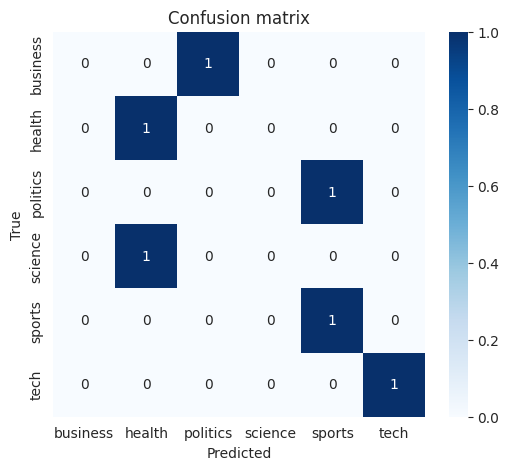

In [15]:
# Confusion matrix
labels_sorted = sorted(df["category"].unique())

cm = confusion_matrix(y_test, pred_test, labels=labels_sorted)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 10) Сохранение модели и тестирование на новых заголовках

Мы сохраним:
1) Word2Vec модель (`.save()`)
2) классификатор (`joblib.dump`)

⚠️ Чтобы предсказывать на новых данных, нам нужно:
- токенизировать заголовок
- получить его вектор через Word2Vec
- передать в классификатор


In [16]:
W2V_PATH = "/news_word2vec.model"
CLF_PATH = "/news_headline_clf.joblib"

w2v.save(W2V_PATH)
joblib.dump(clf, CLF_PATH)

print("Saved Word2Vec:", W2V_PATH)
print("Saved classifier:", CLF_PATH)

Saved Word2Vec: /news_word2vec.model
Saved classifier: /news_headline_clf.joblib


In [17]:
# Загружаем обратно и тестируем
w2v_loaded = Word2Vec.load(W2V_PATH)
clf_loaded = joblib.load(CLF_PATH)

def predict_category(headline: str, w2v_model, clf_model):
    toks = tokenize(headline)
    vec = headline_vector(toks, w2v_model).reshape(1, -1)
    pred = clf_model.predict(vec)[0]
    return pred

test_headlines = [
    "New smartphone announced with advanced AI features",
    "Team wins championship after final match",
    "Scientists discover unusual particle in experiment",
    "Markets fall as oil prices rise",
    "President signs new agreement during summit",
    "Doctors warn about flu outbreak this winter",
]

for h in test_headlines:
    print(f"[{predict_category(h, w2v_loaded, clf_loaded)}]  {h}")

[tech]  New smartphone announced with advanced AI features
[sports]  Team wins championship after final match
[sports]  Scientists discover unusual particle in experiment
[tech]  Markets fall as oil prices rise
[politics]  President signs new agreement during summit
[business]  Doctors warn about flu outbreak this winter


---
# Итоги урока

Вы сделали полноценный NLP-проект “от начала до конца”:
✅ токены → ✅ Word2Vec → ✅ вектора заголовков → ✅ классификация → ✅ метрики → ✅ сохранение → ✅ предсказания на новых данных

---


# 10 заданий на закрепление (код с пропусками)

Формат: **задание → подсказка → код с пропусками**  
Заполняйте `_____`.


## Задание 1

**Задание:** Сделайте столбец len_chars (длина заголовка).  


In [19]:
df["len_chars"] = df["headline"].astype(str).apply(len)
df[["headline","len_chars"]].head()

,headline,len_chars
0,Real Madrid wins dramatic match in extra time,45
1,NBA star scores 50 points in playoff thriller,45
2,Olympic champion sets new world record in sprint,48
3,Apple announces new iPhone with faster chip,43
4,Breakthrough in quantum computing boosts perfo...,52


## Задание 2

**Задание:** Напишите clean_text: lower + regex + strip.  
**Подсказка:** lower(), re.sub


In [20]:
import re
def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

print(clean_text("BREAKING!!! New law in 2026."))

breaking new law in 2026


## Задание 3

**Задание:** Сделайте tokenize: clean_text → word_tokenize → фильтрация isalnum.  
**Подсказка:** word_tokenize, isalnum()


In [22]:
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalnum()]
    return tokens

print(tokenize("Apple announces NEW iPhone!!!"))

['apple', 'announces', 'new', 'iphone']


## Задание 4

**Задание:** Сделайте train_test_split с stratify.  


In [26]:
from sklearn.model_selection import train_test_split

X = df["tokens"]
y = df["category"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

print(len(X_train), len(X_test))

10 8


## Задание 5

**Задание:** Обучите Word2Vec на X_train.  
**Подсказка:** Word2Vec(sentences=..., vector_size=..., window=..., epochs=...)


In [27]:
from gensim.models import Word2Vec

w2v = Word2Vec(
    sentences=list(X_train),
    vector_size=100,
    window=5,
    min_count=1,
    sg=0,
    epochs=10
)

print("vocab:", len(w2v.wv))

vocab: 60


## Задание 6

**Задание:** Выведите 5 самых похожих слов к 'market' (если слово есть).  
**Подсказка:** w2v.wv.most_similar


In [28]:
word = "market"
if word in w2v.wv:
    print(w2v.wv.most_similar(word, topn=5))
else:
    print("word not in vocab")

word not in vocab


## Задание 7

**Задание:** Допишите функцию headline_vector: собрать vecs и усреднить.  
**Подсказка:** np.mean(vecs, axis=0)


In [33]:
import numpy as np

def headline_vector(tokens, w2v_model):
    vecs = []
    for t in tokens:
        if t in w2v_model.wv:
            vecs.append(w2v_model.wv[t])
    if len(vecs) == 0:
        return np.zeros(w2v_model.vector_size, dtype=np.float32)
    return np.mean(vecs, axis=0).astype(np.float32)

## Задание 8

**Задание:** Соберите X_train_vec из токенов и Word2Vec.  
**Подсказка:** np.stack([...])


In [34]:
X_train_vec = np.stack([headline_vector(toks, w2v) for toks in X_train])
X_test_vec  = np.stack([headline_vector(toks, w2v) for toks in X_test])

print(X_train_vec.shape, X_test_vec.shape)

(10, 100) (8, 100)


## Задание 9

**Задание:** Обучите LogisticRegression и посчитайте accuracy.  
**Подсказка:** fit + predict + accuracy_score


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)

pred = clf.predict(X_test_vec)
print("acc:", accuracy_score(y_test, pred))

acc: 0.125


## Задание 10

**Задание:** Сохраните Word2Vec и классификатор.  
**Подсказка:** w2v.save + joblib.dump


In [36]:
import joblib

W2V_PATH = "my_w2v.model"
CLF_PATH = "my_clf.joblib"

w2v.save(W2V_PATH)
joblib.dump(clf, CLF_PATH)

print("saved ✅")

saved ✅
